# **Membuat labels.csv dari folder images:**

In [81]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import shutil

# Path awal gambar
original_dir = '/content/drive/MyDrive/parking_project2/images'
sorted_dir = '/content/drive/MyDrive/parking_project3/sorted_images'

# 1. Baca semua file gambar dan buat label dari nama file
image_files = [f for f in os.listdir(original_dir) if f.endswith(('.jpg', '.png'))]

data = []
for img in image_files:
    match = re.search(r'isi(\d+)', img)
    if match:
        label = int(match.group(1))
        data.append({'filename': img, 'label': label})
    else:
        print(f"❌ Lewati file tidak cocok: {img}")

df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/parking_project3/labels.csv', index=False)

# 2. Split data menjadi train dan val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 3. Buat folder train/val per kelas
for split, split_df in [('train', train_df), ('val', val_df)]:
    for label in split_df['label'].unique():
        os.makedirs(os.path.join(sorted_dir, split, str(label)), exist_ok=True)

    for _, row in split_df.iterrows():
        src = os.path.join(original_dir, row['filename'])
        dst = os.path.join(sorted_dir, split, str(row['label']), row['filename'])
        shutil.copyfile(src, dst)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
❌ Lewati file tidak cocok: isi 4_11.jpg


# **Buat folder Data Validasi**

In [82]:
from sklearn.model_selection import train_test_split
import os, shutil
import pandas as pd

# Baca kembali CSV hasil parsing aman tadi
df = pd.DataFrame(data)
df.to_csv('/content/drive/MyDrive/parking_project3/labels.csv', index=False)

# Split train dan val (stratified untuk seimbang)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Buat folder sorted_images/train/label/ dan val/label/
sorted_dir = '/content/drive/MyDrive/parking_project3/sorted_images'
for split, split_df in [('train', train_df), ('val', val_df)]:
    for label in split_df['label'].unique():
        os.makedirs(os.path.join(sorted_dir, split, str(label)), exist_ok=True)

    for _, row in split_df.iterrows():
        src = os.path.join('/content/drive/MyDrive/parking_project3/images', row['filename'])
        dst = os.path.join(sorted_dir, split, str(row['label']), row['filename'])
        shutil.copyfile(src, dst)


# **Distribusi Gambar Perkelas**

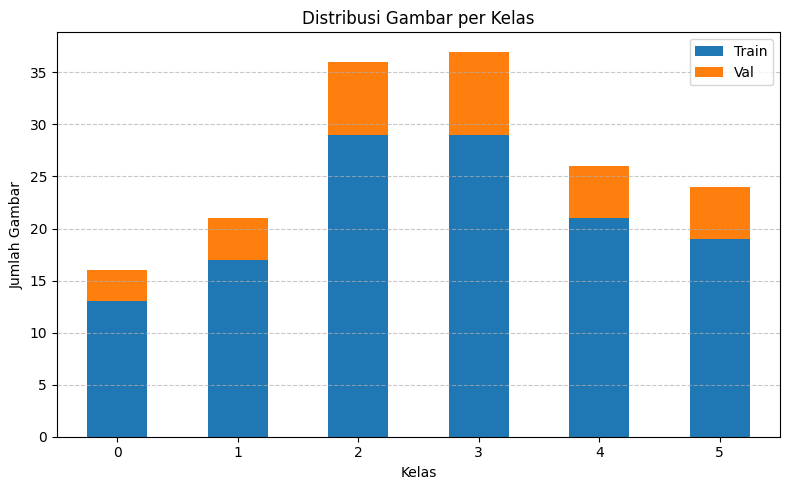

In [118]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the distribution for train and validation sets
train_dist = train_df['label'].value_counts().sort_index()
val_dist = val_df['label'].value_counts().sort_index()

# Combine the distributions into a DataFrame
df_dist = pd.DataFrame({'Train': train_dist, 'Val': val_dist})

# Fill NaN values with 0 in case a class is missing in one split
df_dist = df_dist.fillna(0).astype(int)

# Rename the index to 'Kelas' for clarity in the plot
df_dist.index.name = 'Kelas'

# Now, plot the distribution
df_dist.set_index(df_dist.index)[['Train', 'Val']].plot(kind='bar', stacked=True, figsize=(8,5))
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Custom Dataset class**

# **Membaca gambar + label dari folder dan file CSV**

In [83]:
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image

class ParkingDatasetClassification(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx, 1])  # pastikan integer kelas
        if self.transform:
            image = self.transform(image)
        return image, label

# **Augmentasi Citra**

In [84]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Augmentasi untuk data train
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformasi validasi (tanpa augmentasi)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ImageFolder
train_dataset = datasets.ImageFolder(os.path.join(sorted_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(sorted_dir, 'val'), transform=val_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [85]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

# **Model: ResNet18 (Klasifikasi 6 Kelas)**

In [86]:
import torch.nn as nn
from torchvision import models

num_classes = 6  # 0–5 motor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [87]:
import torchvision.models as models
import torch.nn as nn

# Muat ResNet18 dengan bobot pretrained di ImageNet
resnet18 = models.resnet18(pretrained=True)

# Ubah layer fully connected terakhir agar output-nya sesuai jumlah kelas (6 kelas: isi0–isi5)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),  # 50% dropout
    nn.Linear(num_ftrs, 6)
)


model = resnet18.to(device)

In [88]:
for param in model.parameters():
    param.requires_grad = True

# Hanya fine-tune FC terakhir
resnet18.fc = nn.Linear(num_ftrs, 6)
resnet18.fc.requires_grad = True


# **Loss Dan Optimizer**

In [89]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Kurangi LR tiap 3 epoch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 0.001},
    {'params': model.layer4.parameters(), 'lr': 0.0001},
])


In [90]:
train_losses = []
val_losses = []
val_accuracies = []

# **Training Model**

In [91]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Eval tiap epoch
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")



Epoch 1/10 - Train Loss: 1.7319 | Val Loss: 1.3171 | Val Acc: 0.4375
Epoch 2/10 - Train Loss: 1.1457 | Val Loss: 0.9802 | Val Acc: 0.5312
Epoch 3/10 - Train Loss: 0.8385 | Val Loss: 0.6774 | Val Acc: 0.7188
Epoch 4/10 - Train Loss: 0.6354 | Val Loss: 0.5132 | Val Acc: 0.8125
Epoch 5/10 - Train Loss: 0.6043 | Val Loss: 0.3812 | Val Acc: 0.8750
Epoch 6/10 - Train Loss: 0.4329 | Val Loss: 0.4297 | Val Acc: 0.9062
Epoch 7/10 - Train Loss: 0.3479 | Val Loss: 0.4045 | Val Acc: 0.9062
Epoch 8/10 - Train Loss: 0.3190 | Val Loss: 0.3390 | Val Acc: 0.9062
Epoch 9/10 - Train Loss: 0.3095 | Val Loss: 0.2706 | Val Acc: 0.9062
Epoch 10/10 - Train Loss: 0.4238 | Val Loss: 0.3251 | Val Acc: 0.9062


In [101]:
def evaluate_classification(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"🔍 Akurasi validasi: {acc:.2f}%")

evaluate_classification(model, val_loader)

🔍 Akurasi validasi: 90.62%


# **Train and Validation loss**

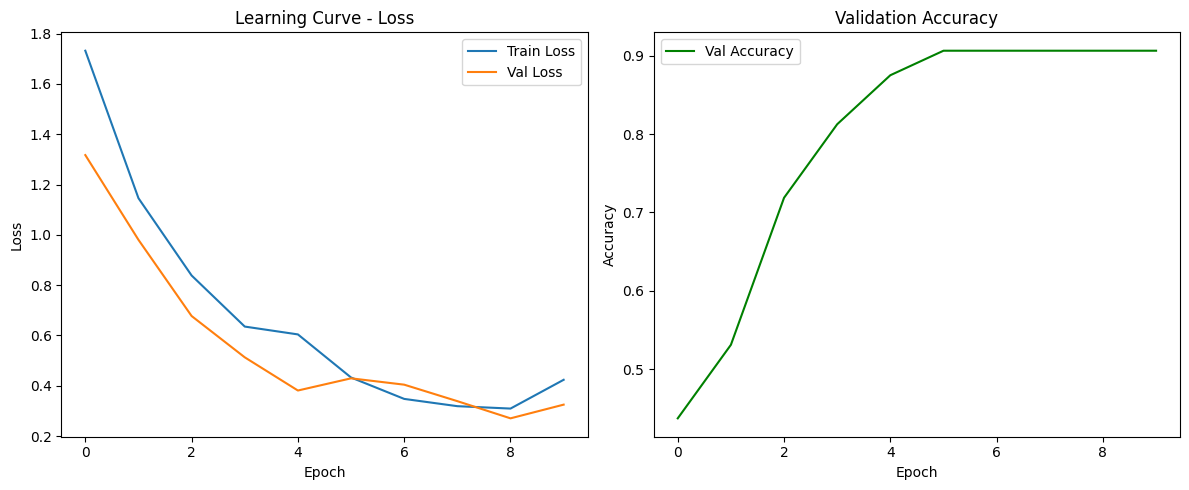

In [102]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **Classification Report**

In [103]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Akurasi:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Akurasi: 0.90625
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         7
           3       0.78      0.88      0.82         8
           4       0.75      0.60      0.67         5
           5       1.00      1.00      1.00         5

    accuracy                           0.91        32
   macro avg       0.92      0.91      0.92        32
weighted avg       0.91      0.91      0.90        32



# **Heatmap(Confussion Matrix)**

✅ Akurasi validasi: 90.62%


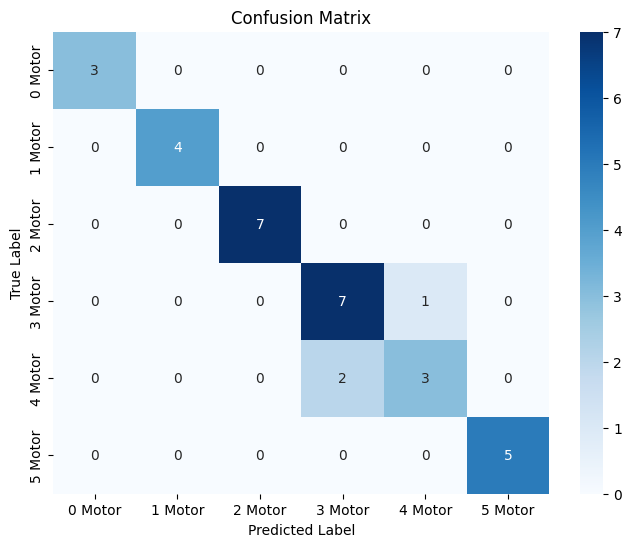

In [104]:
class_names = [f"{i} Motor" for i in range(6)]
evaluate_with_confusion_matrix(model, val_loader, device, class_names)

In [105]:
import matplotlib.pyplot as plt
def predict_and_show_classification(img_path, model):
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, pred_class = torch.max(output, 1)
        pred_class = pred_class.item()

    plt.imshow(image)
    plt.title(f"Prediksi Jumlah Motor: {pred_class}")
    plt.axis('off')
    plt.show()

# **Prediksi Data Baru**

In [109]:
import os
from PIL import Image
import torch

def predict_grid_classification(folder_path, model, transform, device, max_images=10):
    model.eval()
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:max_images]

    correct = 0
    total = 0

    rows, cols = 2, 5
    plt.figure(figsize=(15, 6))

    for i, fname in enumerate(image_files):
        img_path = os.path.join(folder_path, fname)

        # Modify the label extraction logic to handle 'testX.jpg' format
        try:
            # Try extracting label from 'isiX.jpg' format first (for consistency if mixed)
            match_isi = re.search(r'isi(\d+)', fname.lower())
            if match_isi:
                label = int(match_isi.group(1))
            else:
                # If not 'isiX.jpg', try extracting from 'testX.jpg' format
                match_test = re.search(r'test(\d+)', fname.lower())
                if match_test:
                    label = int(match_test.group(1))
                else:
                    # Handle cases where the filename doesn't match either pattern
                    print(f"Warning: Could not extract label from filename: {fname}")
                    # You might want to skip this image or assign a default label
                    continue
        except ValueError:
            print(f"Warning: Could not convert extracted string to integer for filename: {fname}")
            continue # Skip this image if conversion fails

        image = Image.open(img_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            pred = pred.item()

        # Hitung akurasi
        total += 1
        if pred == label:
            correct += 1

        # Tampilkan gambar
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f"{fname}\nPred: {pred}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



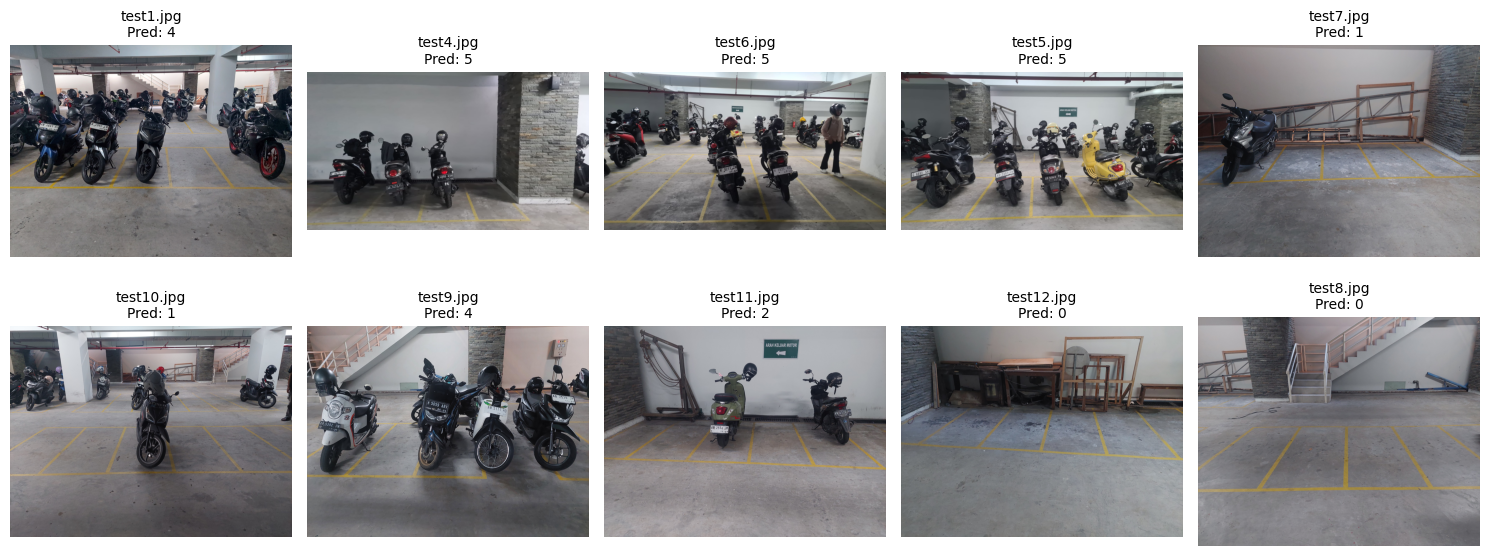

In [110]:
predict_grid_classification(
    "/content/drive/MyDrive/parking_project3/testing",
    model,
    val_transforms,
    device
)

In [116]:
torch.save(model.state_dict(), '/content/drive/MyDrive/parking_project3/parking_model_classification.pth')
print("📁 Model berhasil disimpan.")

📁 Model berhasil disimpan.
